In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys

# Allow imports from 04_Src
sys.path.append("../04_Src")

data_path = "../02_Data/Processed/sp500_model_data_window30.npz"
npz = np.load(data_path, allow_pickle=True)

X_train = npz["X_train"]
X_val = npz["X_val"]
X_test = npz["X_test"]
dates_train = pd.to_datetime(npz["dates_train"])
dates_val = pd.to_datetime(npz["dates_val"])
dates_test = pd.to_datetime(npz["dates_test"])
feature_cols = [str(c) for c in npz["feature_cols"]]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Feature columns:", feature_cols)


X_train shape: (706, 30, 13)
X_val shape: (250, 30, 13)
X_test shape: (488, 30, 13)
Feature columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'ma_5', 'ma_20', 'rolling_vol_20', 'sentiment_mean', 'sentiment_pos_mean', 'sentiment_neg_mean', 'news_count']


In [2]:
log_return_index = feature_cols.index("log_return")
print("Index of log_return:", log_return_index)

# Extract sequences of returns only: shape (samples, window_size)
returns_train = X_train[:, :, log_return_index]
returns_val = X_val[:, :, log_return_index]
returns_test = X_test[:, :, log_return_index]

print("returns_train shape:", returns_train.shape)
print("returns_val shape:", returns_val.shape)
print("returns_test shape:", returns_test.shape)


Index of log_return: 5
returns_train shape: (706, 30)
returns_val shape: (250, 30)
returns_test shape: (488, 30)


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

from models.generative_vae import ReturnsVAE, vae_loss, generate_scenarios_from_window

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seq_len = returns_train.shape[1]

returns_train_t = torch.tensor(returns_train, dtype=torch.float32)
returns_val_t = torch.tensor(returns_val, dtype=torch.float32)

train_dataset = TensorDataset(returns_train_t)
val_dataset = TensorDataset(returns_val_t)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

len(train_loader), len(val_loader)


Using device: cpu


(12, 4)

In [4]:
latent_dim = 12
hidden_dim = 128

vae_model = ReturnsVAE(seq_len=seq_len, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)

optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
beta = 0.1  # weight for KL term

sum(p.numel() for p in vae_model.parameters() if p.requires_grad)


45622

In [5]:
def train_vae_one_epoch(
    model: torch.nn.Module,
    data_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    beta: float = 1.0,
) -> float:
    model.train()
    total_loss = 0.0
    num_batches = 0

    for (x_batch,) in data_loader:
        x_batch = x_batch.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch)
        loss = vae_loss(x_recon, x_batch, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(num_batches, 1)


@torch.no_grad()
def evaluate_vae(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device,
    beta: float = 1.0,
) -> float:
    model.eval()
    total_loss = 0.0
    num_batches = 0

    for (x_batch,) in data_loader:
        x_batch = x_batch.to(device)

        x_recon, mu, logvar = model(x_batch)
        loss = vae_loss(x_recon, x_batch, mu, logvar, beta=beta)

        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(num_batches, 1)


In [6]:
from copy import deepcopy

num_epochs = 50
best_val_loss = float("inf")
best_state = None
patience = 7
epochs_without_improvement = 0

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_vae_one_epoch(
        model=vae_model,
        data_loader=train_loader,
        optimizer=optimizer,
        device=device,
        beta=beta,
    )

    val_loss = evaluate_vae(
        model=vae_model,
        data_loader=val_loader,
        device=device,
        beta=beta,
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} train_loss={train_loss:.6f} val_loss={val_loss:.6f}")

    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        best_state = deepcopy(vae_model.state_dict())
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping for VAE")
            break

if best_state is not None:
    vae_model.load_state_dict(best_state)
    print("Loaded best VAE weights based on validation loss")


Epoch 01 train_loss=0.005309 val_loss=0.001923
Epoch 02 train_loss=0.001567 val_loss=0.000934
Epoch 03 train_loss=0.000953 val_loss=0.000630
Epoch 04 train_loss=0.000723 val_loss=0.000504
Epoch 05 train_loss=0.000656 val_loss=0.000392
Epoch 06 train_loss=0.000550 val_loss=0.000356
Epoch 07 train_loss=0.000493 val_loss=0.000292
Epoch 08 train_loss=0.000463 val_loss=0.000255
Epoch 09 train_loss=0.000413 val_loss=0.000223
Epoch 10 train_loss=0.000404 val_loss=0.000201
Epoch 11 train_loss=0.000367 val_loss=0.000169
Epoch 12 train_loss=0.000341 val_loss=0.000150
Epoch 13 train_loss=0.000329 val_loss=0.000147
Epoch 14 train_loss=0.000408 val_loss=0.000139
Epoch 15 train_loss=0.000317 val_loss=0.000135
Epoch 16 train_loss=0.000312 val_loss=0.000129
Epoch 17 train_loss=0.000299 val_loss=0.000122
Epoch 18 train_loss=0.000306 val_loss=0.000109
Epoch 19 train_loss=0.000392 val_loss=0.000109
Epoch 20 train_loss=0.000297 val_loss=0.000112
Epoch 21 train_loss=0.000300 val_loss=0.000102
Epoch 22 trai

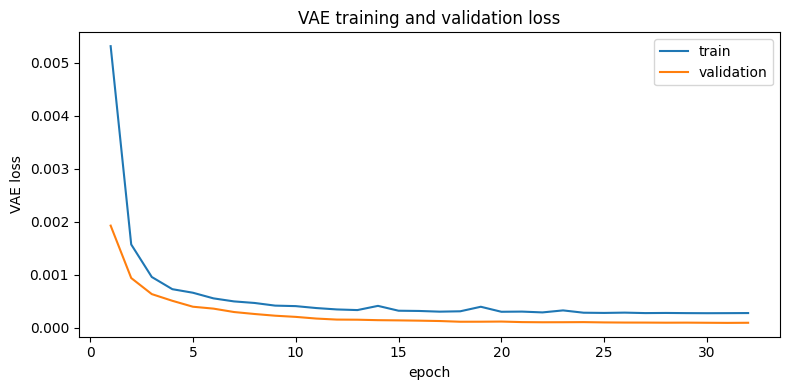

In [7]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, label="train")
plt.plot(epochs_range, val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("VAE loss")
plt.title("VAE training and validation loss")
plt.legend()
plt.tight_layout()
plt.show()


WindowsPath('../05_Results/vae_train_val_loss.png')

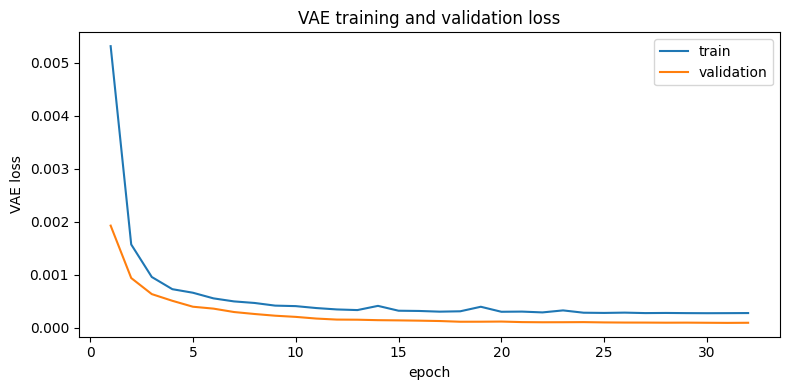

In [8]:
plots_dir = Path("../05_Results")
plots_dir.mkdir(parents=True, exist_ok=True)

vae_loss_plot = plots_dir / "vae_train_val_loss.png"
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, train_losses, label="train")
plt.plot(epochs_range, val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("VAE loss")
plt.title("VAE training and validation loss")
plt.legend()
plt.tight_layout()
plt.savefig(vae_loss_plot, dpi=150)
vae_loss_plot


In [9]:
@torch.no_grad()
def get_reconstructions(model, data, num_samples=5):
    model.eval()
    x_batch = torch.tensor(data[:num_samples], dtype=torch.float32).to(device)
    x_recon, mu, logvar = model(x_batch)
    return x_batch.cpu().numpy(), x_recon.cpu().numpy()

x_true_examples, x_recon_examples = get_reconstructions(vae_model, returns_val, num_samples=5)

x_true_examples.shape, x_recon_examples.shape


((5, 30), (5, 30))

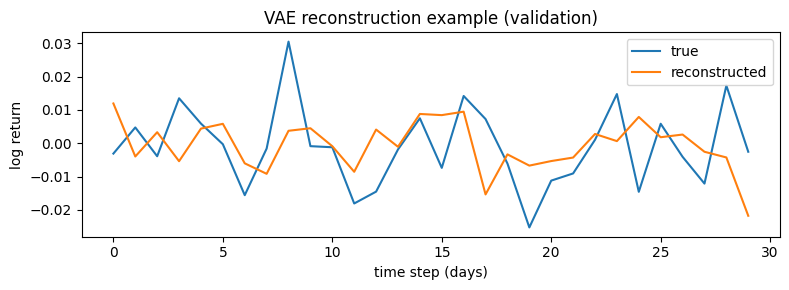

In [10]:
idx = 0  # pick an example between 0 and 4

plt.figure(figsize=(8, 3))
plt.plot(x_true_examples[idx], label="true")
plt.plot(x_recon_examples[idx], label="reconstructed")
plt.title("VAE reconstruction example (validation)")
plt.xlabel("time step (days)")
plt.ylabel("log return")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
checkpoints_dir = Path("../04_Src/models/checkpoints")
checkpoints_dir.mkdir(parents=True, exist_ok=True)

vae_path = checkpoints_dir / "returns_vae.pt"
torch.save(vae_model.state_dict(), vae_path)
vae_path


WindowsPath('../04_Src/models/checkpoints/returns_vae.pt')

### Sampling synthetic return windows from the VAE


In [12]:
import torch
import numpy as np

vae_model.eval()

def sample_returns_from_prior(
    model: ReturnsVAE,
    num_samples: int,
    device: torch.device,
) -> np.ndarray:
    """
    Sample synthetic return windows from the VAE prior.

    Returns an array with shape (num_samples, seq_len).
    """
    seq_len = model.seq_len
    latent_dim = model.latent_dim

    z = torch.randn(num_samples, latent_dim, device=device)
    with torch.no_grad():
        x_recon = model.decode(z)

    return x_recon.cpu().numpy()


num_samples = 500
synthetic_windows = sample_returns_from_prior(vae_model, num_samples=num_samples, device=device)

synthetic_windows.shape


(500, 30)

In [13]:
# Real returns pooled from train and validation sets
real_returns_all = np.concatenate(
    [returns_train.reshape(-1), returns_val.reshape(-1)]
)

# Synthetic returns pooled from all sampled windows
synthetic_returns_all = synthetic_windows.reshape(-1)

def describe_array(name, arr):
    print(name)
    print("  mean:", float(arr.mean()))
    print("  std: ", float(arr.std()))
    print("  min: ", float(arr.min()))
    print("  max: ", float(arr.max()))
    print()

describe_array("Real returns", real_returns_all)
describe_array("Synthetic returns", synthetic_returns_all)


Real returns
  mean: 0.00040161299699658916
  std:  0.014675896868217946
  min:  -0.1276521974728174
  max:  0.0896832325179632

Synthetic returns
  mean: 0.00028685815050266683
  std:  0.004633133765310049
  min:  -0.02426815778017044
  max:  0.021565265953540802



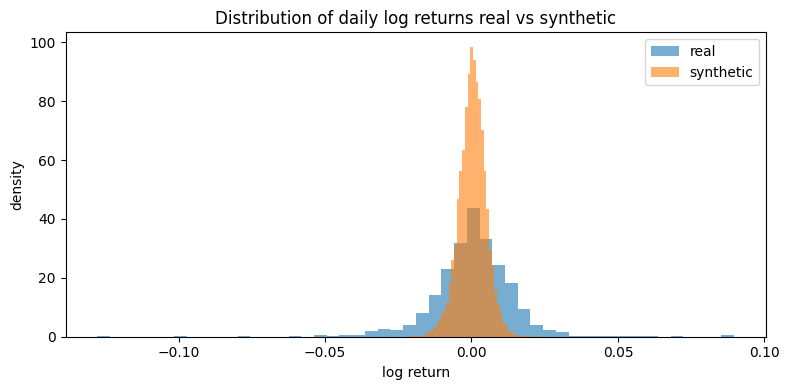

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(real_returns_all, bins=50, alpha=0.6, label="real", density=True)
plt.hist(synthetic_returns_all, bins=50, alpha=0.6, label="synthetic", density=True)
plt.title("Distribution of daily log returns real vs synthetic")
plt.xlabel("log return")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


WindowsPath('../05_Results/vae_real_vs_synthetic_return_distribution.png')

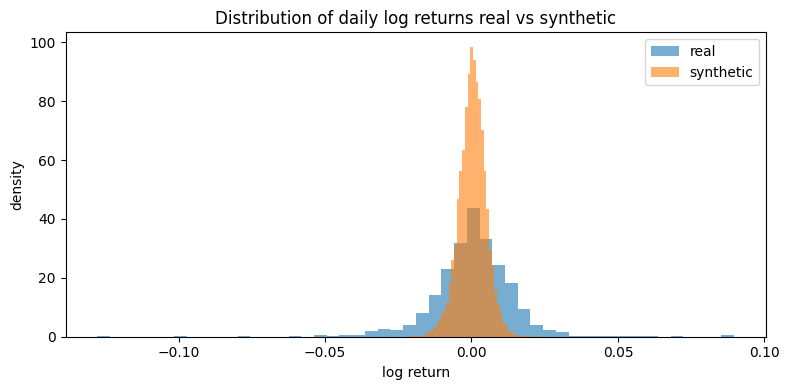

In [15]:
from pathlib import Path

plots_dir = Path("../05_Results")
plots_dir.mkdir(parents=True, exist_ok=True)

dist_plot_path = plots_dir / "vae_real_vs_synthetic_return_distribution.png"
plt.figure(figsize=(8, 4))
plt.hist(real_returns_all, bins=50, alpha=0.6, label="real", density=True)
plt.hist(synthetic_returns_all, bins=50, alpha=0.6, label="synthetic", density=True)
plt.title("Distribution of daily log returns real vs synthetic")
plt.xlabel("log return")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.savefig(dist_plot_path, dpi=150)
dist_plot_path


In [16]:
import pandas as pd
from pathlib import Path

num_samples_to_save = 200  # or any number you like

df_synth = pd.DataFrame(
    synthetic_windows[:num_samples_to_save],
    columns=[f"t_{i}" for i in range(seq_len)],
)

results_dir = Path("../05_Results")
results_dir.mkdir(parents=True, exist_ok=True)

synth_path = results_dir / "vae_generated_return_windows.csv"
df_synth.to_csv(synth_path, index=False)
synth_path


WindowsPath('../05_Results/vae_generated_return_windows.csv')

### Scenario generation from a recent window


In [17]:
# Pick the last validation window as a simple example of "recent" history
ref_idx = -1
ref_window = returns_val[ref_idx]  # shape (seq_len,)

num_paths = 20
noise_scale = 1.0

ref_window_t = torch.tensor(ref_window, dtype=torch.float32)

synth_scenarios_t = generate_scenarios_from_window(
    model=vae_model,
    last_window=ref_window_t,
    num_paths=num_paths,
    noise_scale=noise_scale,
)

synth_scenarios = synth_scenarios_t.cpu().numpy()

synth_scenarios.shape


(20, 30)

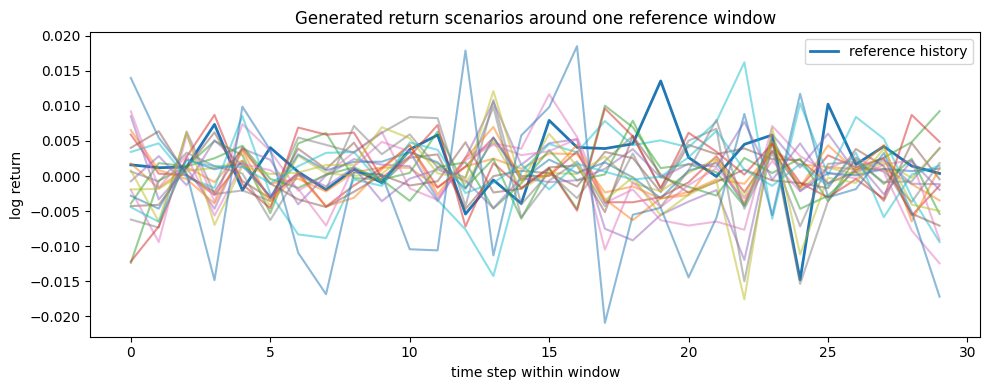

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot the historical window
plt.plot(range(seq_len), ref_window, label="reference history", linewidth=2)

# Plot synthetic scenarios
for i in range(num_paths):
    plt.plot(range(seq_len), synth_scenarios[i], alpha=0.5)

plt.title("Generated return scenarios around one reference window")
plt.xlabel("time step within window")
plt.ylabel("log return")
plt.legend()
plt.tight_layout()
plt.show()


WindowsPath('../05_Results/vae_scenario_paths_example.png')

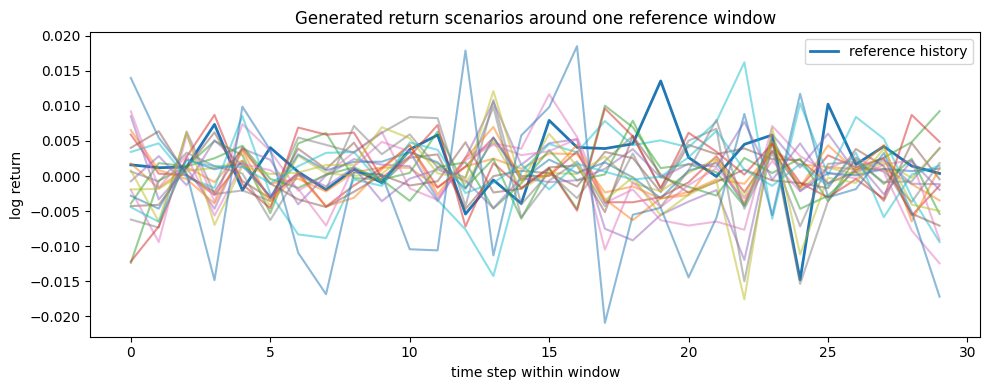

In [19]:
from pathlib import Path

plots_dir = Path("../05_Results")
plots_dir.mkdir(parents=True, exist_ok=True)

scenario_plot_path = plots_dir / "vae_scenario_paths_example.png"

plt.figure(figsize=(10, 4))
plt.plot(range(seq_len), ref_window, label="reference history", linewidth=2)
for i in range(num_paths):
    plt.plot(range(seq_len), synth_scenarios[i], alpha=0.5)
plt.title("Generated return scenarios around one reference window")
plt.xlabel("time step within window")
plt.ylabel("log return")
plt.legend()
plt.tight_layout()
plt.savefig(scenario_plot_path, dpi=150)
scenario_plot_path


In [20]:
import pandas as pd

# Convert each scenario to a row in a dataframe
scenario_ids = [f"scenario_{i}" for i in range(num_paths)]

df_scenarios = pd.DataFrame(
    synth_scenarios,
    index=scenario_ids,
    columns=[f"t_{i}" for i in range(seq_len)],
)

results_dir = Path("../05_Results")
results_dir.mkdir(parents=True, exist_ok=True)

scenarios_csv_path = results_dir / "vae_example_scenarios_from_ref_window.csv"
df_scenarios.to_csv(scenarios_csv_path)
scenarios_csv_path


WindowsPath('../05_Results/vae_example_scenarios_from_ref_window.csv')